In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from hj_mad_ls import HJ_MD_LS

# Hyperparameters
n_neurons = 50  # Number of neurons in the shallow network
learning_rate = 0.01
num_epochs = 1000
batch_size = 100

# Generate data
no_of_samples = 500
noise_level = 1e-3
x = np.linspace(0, 2 * np.pi, no_of_samples)
y = np.sin(x) + noise_level * np.random.randn(*x.shape)  # Add noise to the samples

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Create dataset and dataloader
dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the shallow neural network
class ShallowNet(nn.Module):
    def __init__(self, n_neurons):
        super(ShallowNet, self).__init__()
        self.linear = nn.Linear(1, n_neurons)
        self.coeffs = nn.Parameter(torch.randn(n_neurons, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)      # Compute w_j * x + b_j
        x = self.relu(x)        # Apply ReLU activation
        x = x @ self.coeffs     # Compute sum of c_j * ReLU(...)
        return x

    # def set_parameters(self, new_parameters):
    #     """
    #     Set model parameters from the flattened parameter vector.
    #     This method updates the model's parameters from a single flattened tensor.
    #     """
    #     offset = 0
    #     for param in self.parameters():
    #         param_size = param.numel() 
    #         new_param_values = new_parameters[offset:offset + param_size]
    #         new_param_values = new_param_values.view(param.shape)  
    #         param.data.copy_(new_param_values)  
    #         offset += param_size  

    def set_parameters(self, new_parameters):
        """
        Set model parameters from the flattened parameter vector.
        This method updates the model's parameters from a single flattened tensor.

        Args:
            new_parameters: A flattened tensor containing all parameters.
        """
        offset = 0
        for param in self.parameters():
            param_size = param.numel()  # Total number of elements in the parameter
            # Extract the relevant slice and reshape it to the parameter's original shape
            if len(new_parameters.shape) == 1:
                new_param_values = new_parameters[offset:offset + param_size]
            else:
                new_param_values = new_parameters[0, offset:offset + param_size]  # Access batch dimension
            new_param_values = new_param_values.view_as(param)  # Match the original shape
            param.data.copy_(new_param_values)  # Update parameter
            offset += param_size




# Initialize model, loss function, and optimizer
model = ShallowNet(n_neurons)
criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# HJ_MAD hyperparameters
delta = 10
t = 0.5
int_samples = int(100)
max_iters = 1000
f_tol = 1e-5
sat_tol = 1e-5
delta_dampener=0.8
beta=0.5

# Use HJ_MAD to optimize the model parameters
HJ_MAD_alg = HJ_MD_LS(delta=delta, t=t, int_samples=int_samples, max_iters=max_iters, f_tol=f_tol,sat_tol=sat_tol,delta_dampener=delta_dampener,beta=beta,verbose=False)

# Define the function f (e.g., a loss function based on the model's predictions)
def Objective_function(x, model, inputs, targets):
    """
    Computes the loss based on the given model parameters.

    Args:
        x: Tensor of shape (n_samples, n_features) representing flattened parameters.
        model: The neural network model.
        inputs: Input batch.
        targets: Ground truth values.

    Returns:
        Tensor of shape (n_samples,) containing the loss for each sample.
    """
    n_samples = x.shape[0]
    
    # Initialize list to store losses
    sample_losses = []

    # Compute losses for each sample in the batch
    for i in range(n_samples):
        # Extract parameters for the current sample
        model_params = x[i, :]  # Take the i-th sample
        model.set_parameters(model_params)  # Update model parameters

        # Forward pass and loss computation
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        sample_losses.append(loss.item())

    # Convert the list of losses to a tensor
    return torch.tensor(sample_losses)


# Training loop: Iterate through the epochs
for epoch in range(num_epochs):
    # Iterate through the dataset in batches
    for inputs, targets in dataloader:
        # Define f
        def f(x):
            return Objective_function(x, model, inputs, targets)
        
        # Get the model parameters as a flattened tensor
        parameters = list(model.parameters())
        parameter_vector = torch.cat([param.flatten() for param in parameters])
        parameter_vector = parameter_vector.unsqueeze(0) # shape (1, num_features)

        # Compute Current Loss
        loss_old = f(parameter_vector)  # Compute the loss for the current parameters

        # Run HJ_MAD to optimize the model parameters
        new_parameters, loss, iterations, delta = HJ_MAD_alg.run(f, parameter_vector,delta)  # Run HJ_MAD to optimize the model parameters

        # Update the model parameters with the optimized values
        model.set_parameters(new_parameters)

        # Print the loss before and after optimization
        print(f'Loss before: {loss_old.item():.4f} | Loss after: {loss.item():.4f} | Delta: {delta} | Iterations: {iterations}')
        
    # Print the loss every 100 epochs for monitoring
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Visualise the learned function
plt.figure()
plt.plot(x, y, label='True function')
plt.plot(x, model(x_tensor).detach().numpy(), '--', label='Learned function')
plt.legend()
plt.show()

Epoch [100/1000], Loss: 0.0130
Epoch [200/1000], Loss: 0.0031
Epoch [300/1000], Loss: 0.0014
Epoch [400/1000], Loss: 0.0024
Epoch [500/1000], Loss: 0.0007
Epoch [600/1000], Loss: 0.0029
Epoch [700/1000], Loss: 0.0159
Epoch [800/1000], Loss: 0.0010
Epoch [900/1000], Loss: 0.0018
Epoch [1000/1000], Loss: 0.0010


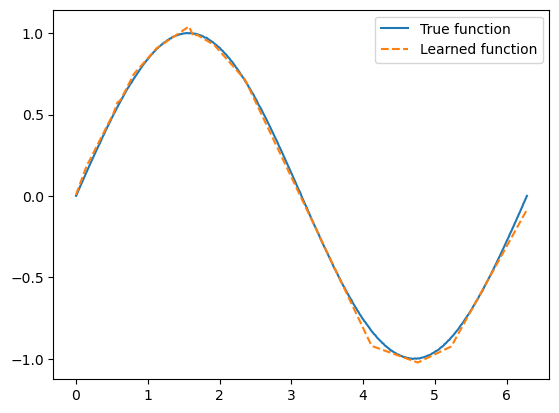

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
n_neurons = 50  # Number of neurons in the shallow network
learning_rate = 0.01
num_epochs = 1000
batch_size = 100

# Generate data
no_of_samples = 500
noise_level = 1e-3
x = np.linspace(0, 2 * np.pi, no_of_samples)
y = np.sin(x) + noise_level * np.random.randn(*x.shape)  # Add noise to the samples

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Create dataset and dataloader
dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the shallow neural network
class ShallowNet(nn.Module):
    def __init__(self, n_neurons):
        super(ShallowNet, self).__init__()
        self.linear = nn.Linear(1, n_neurons)
        self.coeffs = nn.Parameter(torch.randn(n_neurons, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)      # Compute w_j * x + b_j
        x = self.relu(x)        # Apply ReLU activation
        x = x @ self.coeffs     # Compute sum of c_j * ReLU(...)
        return x

# Initialize model, loss function, and optimizer
model = ShallowNet(n_neurons)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Visualise the learned function
plt.figure()
plt.plot(x, y, label='True function')
plt.plot(x, model(x_tensor).detach().numpy(), '--', label='Learned function')
plt.legend()
plt.show()